In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, mean_squared_error
from sklearn.linear_model import Lasso, Ridge, ElasticNet

## Load Data


In [2]:
# load and prep data
with open('./data/training set.pkl', 'rb') as fp:
    
    train_data = pickle.load(fp)
 
train_data.reset_index(drop = True, inplace = True)
train_data.dropna(inplace = True)

y =  train_data['lnpercapitaconsumption']
X = train_data.drop(columns = ['lnpercapitaconsumption'])
# scale 


# split data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.50, random_state=42)
poly = PolynomialFeatures(degree = 2, interaction_only=True)
X_train_2 = poly.fit_transform(X_train)
X_test_2 = poly.fit_transform(X_test)

In [3]:
raw = pd.read_csv('./data/peru_for_ml_course.csv')

rr = raw.loc[raw['lnpercapitaconsumption'].ge(0),:].reset_index(drop = True).dropna()

per_hh_head = rr.loc[y_test.index, 'h_hhsize']

In [4]:
def inex(predicted, actual, level, incl: bool, err: bool):
     
    #the funciton takes in 5 values and returns one value
    #predicted - should be an array of predicted y values according to the model that you used
    #actual - actual values of a training or testing data set, as a dataframe with an index
    #level - scalar which is used to determining the threshold 
    
    
    predicted_threshold = np.zeros(len(y))
    
    if incl is True:
        predicted_threshold = (predicted < np.percentile(predicted,level))
    else:
        predicted_threshold = (predicted > np.percentile(predicted,level))
    
    actual_threshold = np.zeros(len(y))
    
    if err is True and incl is True:
        actual_threshold = (actual > np.percentile(predicted,28))
    elif err is True and incl is False:
        actual_threshold = (actual < np.percentile(predicted,28))
    elif err is False and incl is False:
        actual_threshold = (actual > np.percentile(predicted,28))
    else:
        actual_threshold = (actual < np.percentile(predicted,28))
    
        
    data = pd.DataFrame(index = range(0,len(predicted)), columns = ["actual","predicted"])
    data["actual"] = actual_threshold.values
    data["predicted"] = predicted_threshold
    
    z = np.logical_and(data["actual"], data["predicted"])
    value = len(z[z == True]) / len(predicted)
    
    return value

In [5]:
# train all the models
with open('./models/lassobest.pkl', 'rb') as fp:
    lasso = pickle.load(fp)
    
with open('./models/ridgebest.pkl', 'rb') as fp:
    ridge = pickle.load(fp)
    
with open('./models/elbest.pkl', 'rb') as fp:
    elastic = pickle.load(fp)

C:\Users\Villem\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Lasso from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Villem\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Villem\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator Ridge from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Villem\Anaconda3\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator ElasticNet from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. U

In [6]:
lasso_pred = lasso.predict(X_test_2)
lasso_pred_exp = np.exp(lasso_pred)
ridge_pred = ridge.predict(X_test_2)
ridge_pred_exp = np.exp(ridge_pred)
el_pred = elastic.predict(X_test_2)

In [7]:
national_num_households = 6750000
program_monthly = (880*1e6)/12


def utility(y_pred,level, rho, benefits =program_monthly):

    # pick out poor people
    is_poor = y_pred < level
    num_poor = np.sum(is_poor)
    pct_is_poor = num_poor/y_pred.shape[0]
    #pct_households_incl = 
    national_hh_incl = national_num_households * pct_is_poor
    per_hh_benefits = benefits/national_hh_incl
    # decide how much each poor gets
    gets_benefits = is_poor * per_hh_benefits
    # give the poor money
    add_benefits = y_pred + gets_benefits 
    #utility calculations
    per_capita_benefits = add_benefits/per_hh_head
    numerator = np.power(per_capita_benefits, 1 - rho)
    
    results = np.sum(numerator)/(1 - rho)
    
    return results#, per_capita_benefits, add_benefits, gets_benefits, pct_is_poor, national_hh_incl


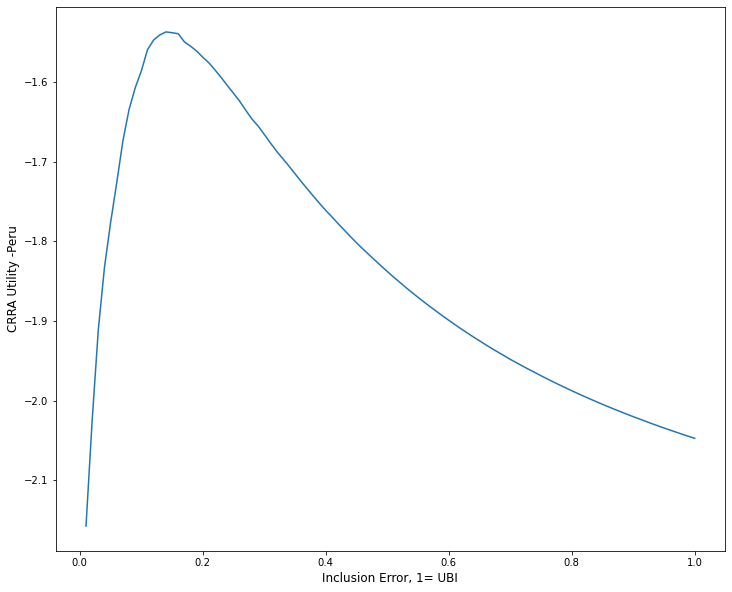

In [8]:
# make the utility graph
cutoff = np.arange(1,101,1)
inclusion = np.zeros(len(cutoff))
ut = inclusion.copy()

for i in range(0,len(cutoff)):
    inclusion[i] = inex(lasso_pred, y_test, cutoff[i], incl = True, err = True) 
    
inclusion

for j in cutoff:
    
    ut[j-1] = utility(lasso_pred_exp, np.percentile(lasso_pred_exp,j), rho = 3)
    
    
plt.figure(1,figsize= (12,10))
plt.plot(cutoff/100,ut)
plt.ylabel('CRRA Utility -Peru', fontsize = 12)
plt.xlabel('Inclusion Error, 1= UBI', fontsize = 12)
plt.savefig('crra_utility.png')